## Create A Network Grid from Raster Grid

This notebook demonstrates how to extract a NetworkModelGrid from a RasterModelGrid using the 'create_network_from_raster' function

In [47]:
import matplotlib.pyplot as plt
import numpy as np

from landlab.grid.create_network import network_grid_from_raster
from landlab.io import read_esri_ascii
from landlab.plot.graph import plot_links, plot_nodes
from landlab.plot.imshow import imshow_grid
from landlab.components import FlowDirectorSteepest

## Create a Raster Model Grid

Now let's create a raster model grid from the .asc data

In [7]:
grid, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_FIXED_VALUE
grid.status_at_node[np.isclose(z, -9999.0)] = grid.BC_NODE_IS_CLOSED

Visualize Basin topography

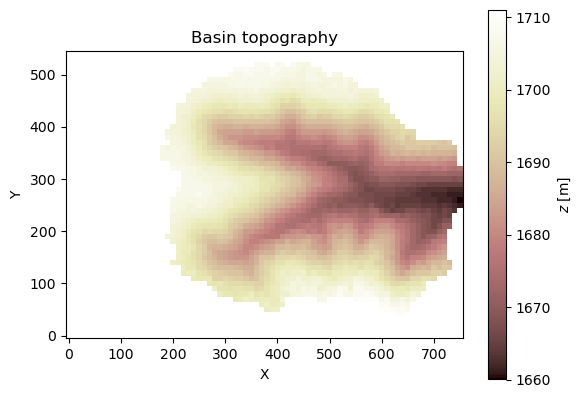

In [8]:
imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

In [9]:
grid.at_node.keys()


['topographic__elevation']

## Create  a Network Model Grid

Now let's create a network model grid using the 'create_network_from_raster' function:

In [11]:
network_grid = network_grid_from_raster(
    grid,
    minimum_channel_threshold=12000.0,
    include=["drainage_area", "topographic__elevation"],
)

In [12]:
network_grid.length_of_link

array([ 10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  14.14213562,  14.14213562,  10.        ,
        14.14213562,  14.14213562,  10.        ,  10.        ,
        14.14213562,  14.14213562,  10.        ,  14.14213562,
        14.14213562,  10.        ,  14.14213562,  10.        ,
        10.        ,  14.14213562,  14.14213562,  14.14213562,
        10.        ,  10.        ,  14.14213562,  10.        ,
        10.        ,  14.14213562,  14.14213562,  14.14213562,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  14.14213562,  14.14213562,
        14.14213562,  14.14213562,  14.14213562,  14.14213562,
        14.14213562,  14.14213562,  10.        ,  10.        ,
        10.        ,  14.14213562,  14.14213562,  10.        ,
        10.        ,  14.14213562,  14.14213562,  14.14213562,
        14.14213562,  10.        ,  10.        ,  10.  

## Let's plot our network

The nodes are numbered in *landlab* convention of lower-left to upper-right.

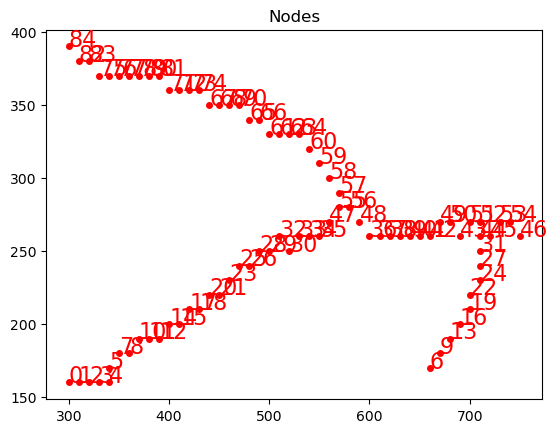

In [13]:
plot_nodes(network_grid, markersize=4)
plt.title("Nodes");

As are the links,

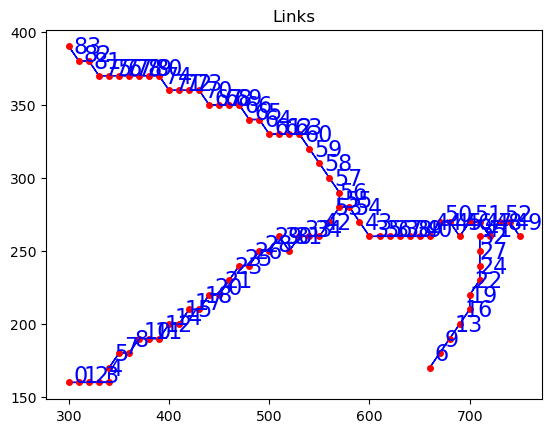

In [14]:
plot_nodes(network_grid, with_id=False, markersize=4)
plot_links(network_grid)
plt.title("Links");

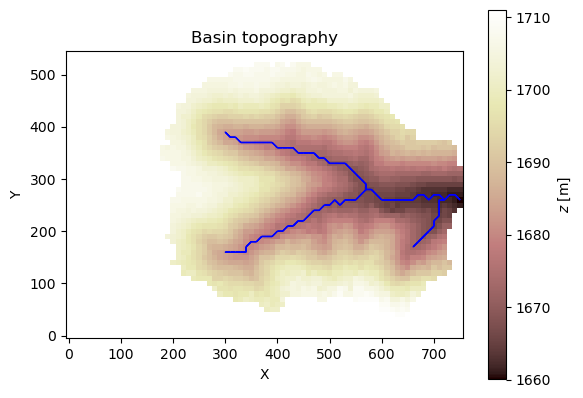

In [15]:
imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)
plot_links(network_grid, with_id=False)

In [16]:
if len(network_grid.nodes_at_link) > (len(network_grid.nodes) - 1):
    print("there are duplicate links")
else:
    print("link count looks good!")

link count looks good!


# Reduce the numer of nodes in channel segments

In the above, we have preserved every node in each channel segment. You can reduce the number of nodes in each segment by passing a *reducer* to the *network_grid_from_raster* function. A *reducer* is simply a function that accepts a list of nodes defining a segment. Although you can write your own, *landlab* provides a set of commonly used reducers.

In [38]:
from landlab.grid.create_network import (
    AtMostNodes,
    JustEndNodes,
    SpacingAtLeast,
    spacing_from_drainage_area,
)

As an example, the following will retain only the downstream and upstream node of each segment.

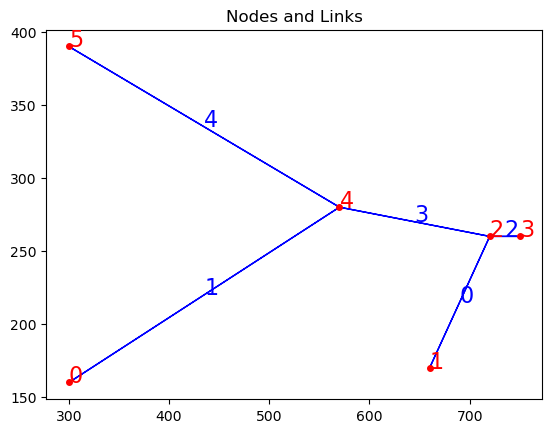

In [39]:
network_grid = network_grid_from_raster(
    grid,
    reducer=JustEndNodes(),
    minimum_channel_threshold=12000.0,
    include=["drainage_area", "topographic__elevation"],
)

plot_nodes(network_grid, markersize=4)
plot_links(network_grid)
plt.title("Nodes and Links");

Reduce to a maximum number of nodes per segment (including end nodes), use *AtMostNodes*,

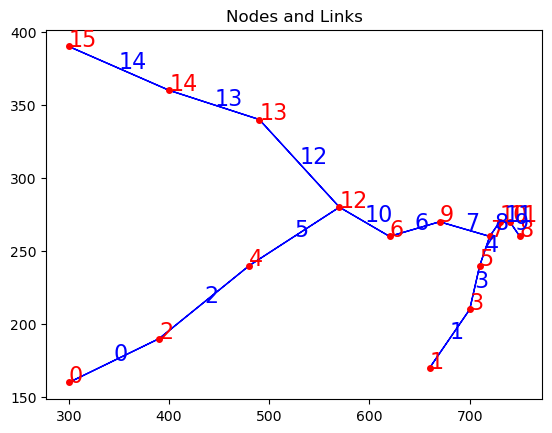

In [40]:
network_grid = network_grid_from_raster(
    grid,
    reducer=AtMostNodes(count=4),
    minimum_channel_threshold=12000.0,
    include=["drainage_area", "topographic__elevation"],
)

plot_nodes(network_grid, markersize=4)
plot_links(network_grid)
plt.title("Nodes and Links");

# run flow router
fd = FlowDirectorSteepest(network_grid, "topographic__elevation")
fd.run_one_step()

In [63]:
network_grid.nodes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [60]:
network_grid.at_node['flow__receiver_node']

array([ 2,  3,  4,  5, 12,  7,  9, 10,  8,  7, 10,  8,  6, 12, 13, 14])

In [62]:
network_grid.at_link['flow__link_direction']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int8)

In [35]:
network_grid.node_at_link_head # head is outlet

array([ 2,  3,  4,  5,  7, 12,  9,  7, 10,  8,  6, 11, 12, 13, 14])

In [36]:
network_grid.node_at_link_tail # tail is inlet

array([ 0,  1,  2,  3,  5,  4,  6,  9,  7, 11, 12, 10, 13, 14, 15])

In [48]:
# add topographic elevation


In [54]:
network_grid.at_node.keys()

['topographic__elevation',
 'drainage_area',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope']

In [57]:
network_grid.at_node['topographic__steepest_slope']
network_grid.at_node['flow__link_to_receiver_node']

array([ 0,  1,  2,  3,  5,  4,  6,  8, -1,  7, -1,  9, 10, 12, 13, 14])

In [59]:
network_grid.at_node['flow__receiver_node']

array([ 2,  3,  4,  5, 12,  7,  9, 10,  8,  7, 10,  8,  6, 12, 13, 14])

In [58]:
network_grid.at_node.keys()

['topographic__elevation',
 'drainage_area',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope']

Another option is to specify a spacing at each node. The spacing can be either a scalar, meaning the spacing is the same for every node, or can vary from node to node. An example of the latter is a spacing that depends on upstream area at each node.

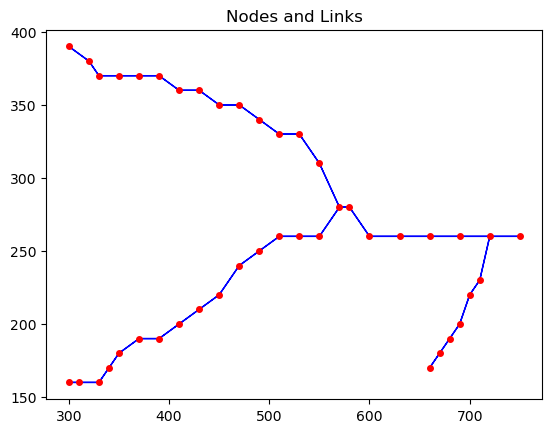

In [37]:
spacing = spacing_from_drainage_area(grid.at_node["drainage_area"])

network_grid = network_grid_from_raster(
    grid,
    reducer=SpacingAtLeast(grid.xy_of_node, spacing),
    minimum_channel_threshold=12000.0,
    include=["drainage_area", "topographic__elevation"],
)

plot_nodes(network_grid, with_id=False, markersize=4)
plot_links(network_grid, with_id=False)
plt.title("Nodes and Links");